In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('/content/emotion-labels-train.csv',encoding='latin1')
test = pd.read_csv('/content/emotion-labels-test.csv',encoding='latin1')
val = pd.read_csv('/content/emotion-labels-val.csv',encoding='latin1')

In [4]:
df = pd.concat([train, test, val], ignore_index=True)

In [5]:
df.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game â¤ï¸â¤ï...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7102 non-null   object
 1   label   7102 non-null   object
dtypes: object(2)
memory usage: 111.1+ KB


In [7]:
df.tail()

,text,label
7097,Common app just randomly logged me out as I wa...,sadness
7098,"I'd rather laugh with the rarest genius, in be...",sadness
7099,If you #invest in my new #film I will stop ask...,sadness
7100,"Just watched Django Unchained, Other people ma...",sadness
7101,@KeithOlbermann depressing how despicable Trum...,sadness


In [8]:
df.shape

(7102, 2)

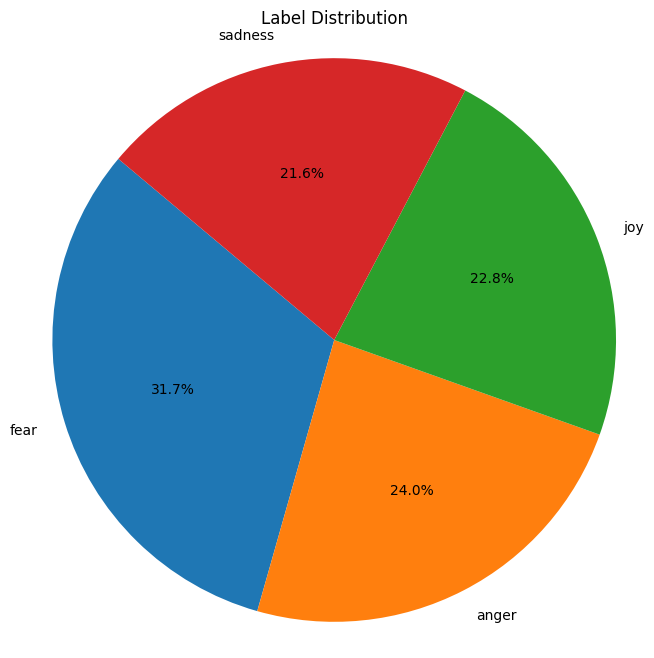

In [9]:
label_counts = df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

In [10]:
#Tokenize and preprocess the text data

In [11]:
max_words = 5000  # You can adjust this based on your dataset
max_sequence_length = 100  # You can adjust this based on your dataset

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [12]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
class_names = label_encoder.classes_

In [13]:
#Splitting of data train and test

In [14]:
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [15]:
train_data = torch.tensor(train_data, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

In [16]:
batch_size = 34 # Adjust as needed
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [17]:
#Text emotion Dectection

In [18]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x]
        x = torch.cat(x, 1)
        x = self.fc(x)
        return x

In [19]:
vocab_size = max_words
embedding_dim = 100 # You can adjust this based on your dataset
num_filters = 128  # You can adjust this based on your dataset
filter_sizes = [3, 4, 5]  # Filter sizes for convolutions
num_classes = len(label_encoder.classes_)  # Number of emotion classes

In [20]:
#CNN model

In [21]:
# Create the CNN model
cnn_model = CNNTextClassifier(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [23]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [24]:
#trainning model

Epoch 1 - Loss: 1.2970845521915526, Accuracy: 40.49%
Epoch 1 - Validation Loss: 1.1551259401298704, Validation Accuracy: 51.51%
Epoch 2 - Loss: 0.7828797811553592, Accuracy: 75.37%
Epoch 2 - Validation Loss: 0.9782697842234657, Validation Accuracy: 59.47%
Epoch 3 - Loss: 0.3796028961383161, Accuracy: 91.53%
Epoch 3 - Validation Loss: 0.7670812550045195, Validation Accuracy: 72.48%
Epoch 4 - Loss: 0.2140664011461749, Accuracy: 95.65%
Epoch 4 - Validation Loss: 0.7785801241795222, Validation Accuracy: 71.50%
Epoch 5 - Loss: 0.1657380875576997, Accuracy: 96.73%
Epoch 5 - Validation Loss: 0.7550365846781504, Validation Accuracy: 73.89%
Epoch 6 - Loss: 0.15675921229246473, Accuracy: 96.60%
Epoch 6 - Validation Loss: 0.7436451088814509, Validation Accuracy: 75.37%
Epoch 7 - Loss: 0.15817716294744363, Accuracy: 96.71%
Epoch 7 - Validation Loss: 0.7033352348066512, Validation Accuracy: 76.07%
Epoch 8 - Loss: 0.15777716685330406, Accuracy: 96.67%
Epoch 8 - Validation Loss: 0.7549210694574174, V

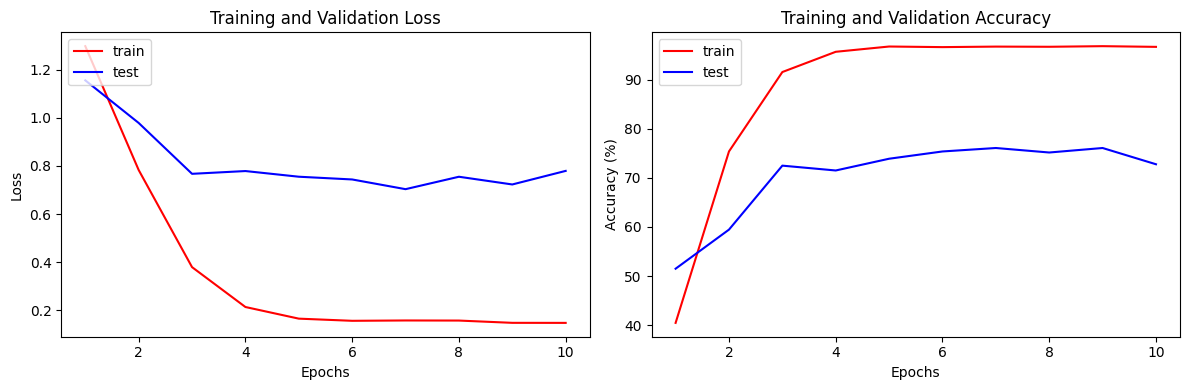

In [25]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10  # Adjust as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Print training loss and accuracy for this epoch
    print(f"Epoch {epoch+1} - Loss: {avg_train_loss}, Accuracy: {train_accuracy:.2f}%")

    # Validation
    cnn_model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = cnn_model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation loss and accuracy for this epoch
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'r', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['train', 'test'], loc='upper left')

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'r', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.show()


In [30]:
#Training and Validation Accuracy

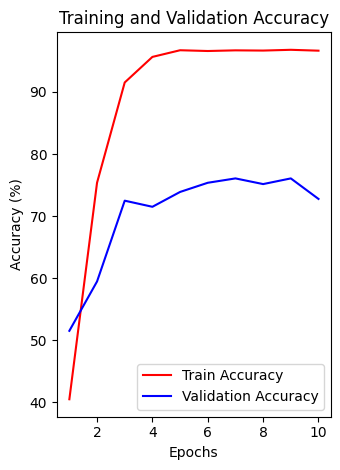

In [31]:
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'r', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
#Training and Validation Loss

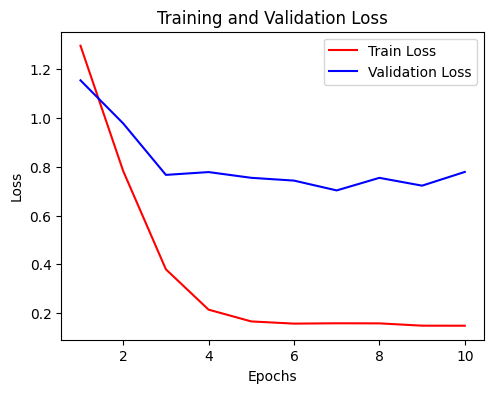

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'r', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [34]:
#Evaluation on the validation set

In [35]:
cnn_model.eval()
val_preds = []
val_true = []

for data, labels in val_loader:
    data, labels = data.to(device), labels.to(device)
    with torch.no_grad():
        outputs = cnn_model(data)
    _, predicted = torch.max(outputs, 1)
    val_preds.extend(predicted.cpu().numpy())
    val_true.extend(labels.cpu().numpy())

In [36]:
#Calculate evaluation metrics

In [37]:
# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

val_accuracy = accuracy_score(val_true, val_preds)
val_report = classification_report(val_true, val_preds, target_names=label_encoder.classes_)

print(f"Validation Accuracy: {val_accuracy}")
print("Validation Report:\n", val_report)

Validation Accuracy: 0.7276565798733287
Validation Report:
               precision    recall  f1-score   support

       anger       0.84      0.57      0.68       327
        fear       0.86      0.72      0.78       432
         joy       0.87      0.78      0.83       352
     sadness       0.50      0.85      0.63       310

    accuracy                           0.73      1421
   macro avg       0.77      0.73      0.73      1421
weighted avg       0.78      0.73      0.74      1421



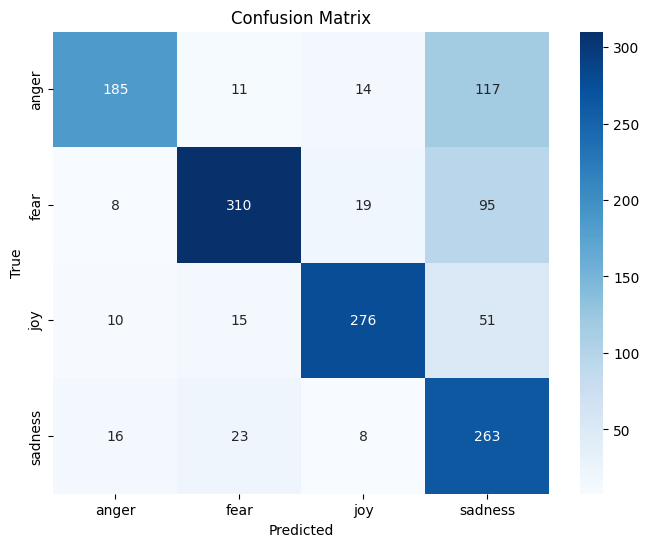

In [38]:
# Evaluate the model and get predicted labels
cnn_model.eval()
val_preds = []
val_true = []

for data, labels in val_loader:
    data, labels = data.to(device), labels.to(device)
    with torch.no_grad():
        outputs = cnn_model(data)
    _, predicted = torch.max(outputs, 1)
    val_preds.extend(predicted.cpu().numpy())
    val_true.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(val_true, val_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
